# The convolution for the mathematically mature reader

Who hasn't heard of this

$$(f \ast g)(x) = \int_{\mathbb{R}} f(x-y)g(y)dy$$

aka the convolution. From the mathematical standpoint it is a weird operation, not really beacuse of its definition, which is rather straight forward, but because it seems to pop up in seemingly unrealted contexsts, where it often acts as a deus ex machina to save the day.

A classical example is the Poisson equation on $\mathbb{R}^d$

$$\Delta u = f$$

which is elegantly solved by the function $u(x) = (f \ast G_d)(x)$, where $\Delta G_d = \delta_0$, the Dirac delta in zero. Another, perhaps more basic one, is the density of the sum of two independet random variables, which turns out to be the convolution of the two densities.

The idea is often that this operation smears one function onto the other, as nicely visualized in the <a url='https://en.wikipedia.org/wiki/Convolution'>wikipedia article</a>, which I'd consider a prerequisite for following this notebook. What I always found more obscure is how an integral defined on the whole real line (or worse $\mathbb{R}^d$!) can turn out to be a useful tool in areas such as machine learning and image processing, where it can produce interesting resulsts such as this one.

<img src='images/Figure_1_convolution_ARROW.png' style='width: 1000px'>

This notebook aims to try and build a bridge between the abstract definition of the convolution and its nice mathematical properties, and the more practical uses and efficient implementations which in turn use some of those nice properties. The hope is that eventually this application oriented veiw will shine some intuition onto what the convolution really does.


## Step 1: from functions to vectors

As a mathematician, I feel like I'm lacking ground beneath my feet if I can't specify a domain for the functions I define. The convolution itself has a lot of possible domains of definition. A simple choice would be the space of absolutely integrable functions, so that $\ast : L^1(\mathbb{R}) \times L^1(\mathbb{R}) \rightarrow L^1(\mathbb{R})$, but it doesn't really matter. What matters is that the convolution takes a couple of functions and returns a function, which is far from an operation that takes in an image and spits out another one.

Though giving two vectors to numpy it seems to have no problem convolving them.

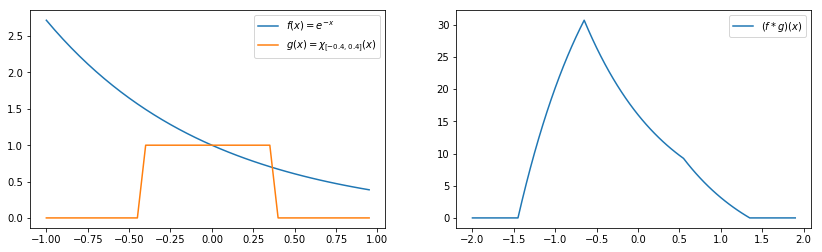

In [1]:
%matplotlib inline 

import numpy as np
from matplotlib import pyplot as plt

# defining grid
x = np.arange(-1,1, 0.05)
cx = np.arange(-2,2, 0.05)

# defining vectors
f = np.exp(-x)
g = np.array([1. if k < 0.4 and k > -0.4 else 0. for k in x])

# plotting
fig1, axs = plt.subplots(1,2, figsize=(14,4))
axs[0].plot(x, f, label='$f(x) = e^{-x}$')
axs[0].plot(x, g, label='$g(x) = \chi_{[-0.4,0.4]}(x)$')
axs[1].plot(cx[:-1], np.convolve(f,g), label='$(f * g)(x)$')
axs[0].legend()
axs[1].legend()

The fact we defined the two vectors $f$ and $g$ as discretized versions of the functions $f(x) = e^{-x}$, and $g(x) = \chi_{[-0.4,0.4]}(x)$ gives us a clue as how to extend this operation from functions on the real line to vectors, which one can still see as functions on $\{1,...,n\}$.

There's two ways to go about this. The first and simplest is to consider the vector convolution done by numpy as an approximation of the convolutional integral considered as a Riemann sum

$$(f \ast g)(x) = \int_{\mathbb{R}} f(x-y)g(y)dy = \lim_{L \rightarrow \infty} \int_{-L}^L f(x-y)g(y)dy = 
\lim_{L \rightarrow \infty} \lim_{n \rightarrow \infty}
\frac{2L}{n} \sum_{k=-nL}^{nL} f\left (x-\frac kn \right)g\left(\frac kn \right)$$

if we cut the limit short at $n=1$ we obtain a discrete formula for the convolution

$$(f \ast g)(x) \approx \lim_{L \rightarrow \infty} \sum_{k=-L}^{L} f(x - k)g(k)$$

equivalent to approximating the integral in the definition with the sum of the area of recatngles of width $1$.

It turns out that some ideas from measure theory can be used to define the discrete convolution as an exact opretion, without needing to consider any approximations. Indeed for any measurable group $(G, \mathcal{A}, \mu)$ we can define the convolution as

$$(f \ast g)(x) = \int_G f(xy^{-1})g(y)d\mu(y)$$

where $y^{-1}$ is just the group invrse of $y$. So considering the group $(\mathbb{Z},+)$ with the counting measure $\#(A) = |A|$ for every $A \in \mathcal{P}(\mathbb{Z})$ we get

$$(f \ast g)(x) = \int_{\mathbb{Z}} f(x-y)g(y)d\#(y)$$

better known as the sum

$$(f \ast g)(i) = \sum_{j \in \mathbb{Z}} f(i-j)g(j)$$

where I've preferred to indicate $x$ with $i$ to emphasize its discrete nature.

Whether we choose to see the discrete convolution as the approximation of the one defined on the real numbers or as its own operation we end up with an infinite sum. Unfortumately no computer will actually be able to sum an infinite amount of numbers in a finite amount of time. There's no way around this, so we have to limit ourselves to functions on $\mathbb{Z}$ having finite support. This way for every $i$ we only have to compute a finite amount of sums in practice. 

From now on then we'll intepret the convolution of two functions $f,g:\mathbb{Z} \rightarrow \mathbb{R}$ with finite support as the nonzero piece of graph resulting from their true convolution.

The exact values of this object depend on where we choose our functions to have nonzero values. We could choose $f$ to be different from zero in $\{1,...,10\}$ while $g$ to be non zero way over at $\{1200,...,1220\}$.

A simple choice is undoubtedly to choose supp$(f) = \{1,...,n\}$ and supp$(g) = \{1,...m\}$ for some $n,m \in \mathbb{N}$. This way for the sum above to contain some non zero terms the following conditions must be satisfied

$$
    \left\{
        \begin{array}{ll}
            0 \leq i - j \leq n \; \; \; \; \; \text{for $f$ to be nonzero}\\
            0 \leq j \leq m \; \; \; \; \; \text{for $g$ to be nonzero}
        \end{array}
    \right.
$$

which is easily solved by $\max \{0,i-n\} \leq j \leq \min \{i,m\}$. This set of indices is not always non-empty.
If $i<0$ infact $\max \{0,i-n\} = 0$, but $\min \{i,m\} = i < 0$, and so we'd have to carry out the sum over the set $0 \leq j \leq i < 0$, in which every element is bigger and smaller than $0$ at the same time. This set clearly does not exist. A similar situation verifies when $i > n+m$.

In other words the $i$s for which the sum does not consist of all zeros are $0 \leq i \leq n+m$. This is actually good news, since we can limit ourselves to evaluating and plotting the convolution just for these indices, knowing that it will be zero everywhere else.

This is all we need to implement the convolution. Here I treat the very special case in which $m = n$. To further simplify the code we can note that when $i<n$ we always have $\max \{0,i-n\} = 0$ and $\min \{i,n\} = i$, and while the converse is true when $i \geq n$. In my opinion this makes the code a bit more readable than having to include all those $\min$s and $\max$s.

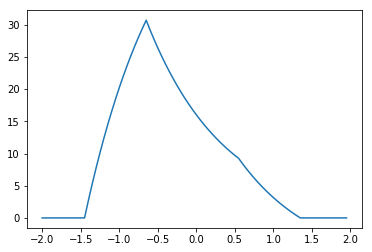

In [5]:
n = len(x)
conv = np.zeros(2 * n)
for i in range(n):
    conv[i] = np.sum(f[i::-1] * g[:i+1])
    conv[n+i] = np.sum(f[:i:-1] * g[i+1:])
    
plt.plot(cx, conv)

Which as you can hopefully see, looks just like the one done by numpy. 

## Step 2: from sums to matrices

Looking back at the measure theoretic formulation, it's rather obvious that the convolution operator, essentially being an integral, is bilinear and symmetric.
Fixing one function as 'the weight' or 'filter' and the other as 'the input' the convolution becomes a linear operator

$$\ast : L^1(\mathbb{Z}) \rightarrow L^1(\mathbb{Z})$$
 $$ f \longmapsto (f \ast w)$$
 
And if linear algebra ever taught us anything, is that any linear operator can be represented by a matrix. In this case it would give rise to an infinite dimensional matrix, but again limiting ourselves to finite support functions, only a finite amount of entries will be nonzero.

More precisely if like before we choose the filter $w$ to have $m$ entries and the input $f$ to have $n$, we know that the resulting function (or at this point, vector) will have $n+m$ nonzero entries. Therefore we can express the convolution as an $m+n \times n$ dimensional matrix, with its rows just being the coefficients $w_{i-j}$ of the sum above for every $i \in \{1,...,n+m\}$.

Computationally this approach is a bit wasteful, since the majority of these $w_{i-j}$ will have to be set to zero. Indeed for $i=1$ the supports of the two functions only cross in one place, namely $j = 1$, and the rest will have to be set to zero. This action corresponds to evaluating the filter $w$ in some spots outside of its support, and this is where the idea of sliding the filter above the function comes from.

$$
(f \ast w) = Wf = \begin{bmatrix}
    w_{1-1} & 0 & \cdots & \cdots & \cdots & 0 \\
    w_{2-1} & w_{2-2} & 0 & \cdots & \cdots & 0 \\
    \vdots & \ddots & \vdots  & &  & \vdots\\
    w_{n-0} & \cdots & w_{n-j} & \cdots & \cdots & w_{n-n} \\
    \vdots & & & \ddots & & \vdots \\
    0 & \cdots & \cdots & \cdots & 0 & w_{n-0}
\end{bmatrix}
\begin{bmatrix}
    f_1 \\
    f_2 \\
    \\
    \vdots \\
    \\
    f_n
\end{bmatrix}
$$

In this representation is quite evident that what we did is just to reverse the weight components $w_i$ and slid them across the matrix, starting from the left towards the right, cutting the matrix when the weight disappears entirely. Matrices like these are called circulant, and, I kid you not, they actually form their little algebra.

Here's the correspoding python code.

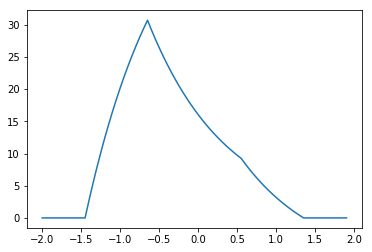

In [6]:
convmatz = np.zeros((2 * L - 1, L))
for i in range(2 * L - 1):
    for j in range(L):
        if (i <= L and j <= i) or (i > L and j  > i - L):
            convmatz[i,j] = g[L-i+j-1]
conv2 = np.dot(convmatz, f)

plt.plot(cx[:-1], conv2)

## Application to image smoothing and edge detection

This idea, virtually unchanged, is used in image denoising and compression. What if we have an image like the roses shown at the start of this notebook that looks rather pixelated, and we want to blur it so that this effect is less evident?

<img src='images/Figure_2_original_image.png' style='height: 300px;'>

A commonly adopted solution is given by applying (read convolving) a gaussian filter to the image, usually taken on the small area around $0$ where the output of the function $e^{-(x^2+y^2)/2}$ is not negligible. Typically this small area is organized in a grid of $5 \times 5$  pixels, or more rarely $9 \times 9$.

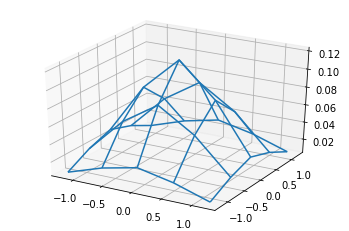

In [3]:
from mpl_toolkits.mplot3d import axes3d

# building a 5x5 gaussian weight
weight_size = 5
distx = np.linspace(-1.2, 1.2, weight_size)
X, Y = np.meshgrid(distx, distx)

weight = np.exp(-X*X-Y*Y)
weight = weight / np.sum(weight)

# plotting filter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, weight)

For the moment let's limit ourselves to black and white images, usually represented by a 2d-array having values in $[0,1]$ or $\{0,...,255\}$, depending on the format we're using. For our purposes we can think of them as functions from a grid in $\mathbb{Z}^2$ to the real numbers.

The idea is that by convolving this image with the gaussian filter it will become more homogenous, since every pixel will share the values of its neighbours, albeit less so the more we get far from it. This intuition is reminiscent of the convolution on the real domain, whose output inherits the regularity of the most regular of the two functions given as input. For instance, if $f$ isn't differentiable while $g \in C^1(\mathbb{R})$ then

$$\partial_x (f \ast g)(x) = \partial_x \int_{\mathbb{R}} f(y)g(x-y)dy =  \int_{\mathbb{R}} f(y)\partial_x g(x-y)dy
$$

where the last step is due to <a url='https://en.wikipedia.org/wiki/Dominated_convergence_theorem'>Lebesgue's dominated convergence theorem</a>. Hence $\partial_x (f \ast g)(x)$ is just $(f \ast g')(x)$.

While we could define the convolution for finite-support functions on $\mathbb{Z}^2$ the same way we did before in $\mathbb{Z}$ and find the indices for which the functions have nonzero values, this isn't really mathematically interesting and will make the code more complex. Here I've preferred to flatten every 2d-array involved and consider images as vectors, thus recycling the previous code and ideas.

In the following code four operations are performed:

1. I take a random image I found on the internet and downsample it taking one pixel every 6 in each direction
2. turn said image into black and white by mixing the 3 RGB channels in the right proportions
3. add a 4 pixel wide frame around the image
4. flatten the image to make it into a vector

Step three is called padding, and it's commonly used to deal with borders when applying convolutions. When the weight reaches the edge of the image infact we have three choices:

1. wrap it around the image and make it come out the other side. This idea is from circular convolution, which is just the convolution defined on the circle group. In our case though this is undesirable since it means that the pixels near the edge will share values with the pixels on the opposite side.
2. cutting the weight
3. padding the image up to the point in which the supports of the weight and the image are disjoint.

Options 2 and 3 are both ok in our case, but I'll go ahead and choose option three since it's more consistent with the previous functional approach.

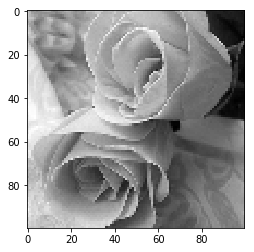

In [2]:
from matplotlib import image as mpimg

# importing and downsampling
image = mpimg.imread('images/Beautiful-Pink-Rose.jpg')[::6,::6]

# turning to grayscale
r,g,b = image[:,:,0], image[:,:,1], image[:,:,2]
gray_image = 0.299 * r + 0.587 * g + 0.114 * b

plt.imshow(gray_image, cmap=plt.get_cmap('gray'))

In [5]:
# padding
image_padding = ((weight_size - 1, weight_size - 1), (weight_size - 1, weight_size - 1))
flat_image = np.pad(gray_image, image_padding, 'constant')

# flattening
image_size = flat_image.shape[0]
flat_image = flat_image.flatten()

We can conveniently use numpy's pad function to make the weight matrix. The weight is currently a $5 \times 5$ array, while the padded image is much larger. We need a matrix of size $\texttt{image_size} \times \texttt{image_size}$.

Since we already did build a circulant matrix from scratch, we'll let scipy's linear algebra package do the hard work for us this time around.

In [6]:
# padding and flattening weight
weight_padding = (
    (0, image_size - weight_size), 
    (0, image_size - weight_size)
) 
flat_weight = np.pad(weight, weight_padding, 'constant').flatten()

# building circulant matrix
from scipy import linalg
image_conv_mat = linalg.circulant(flat_weight)

And that's it, now blurring the image is as simple as doing a dot product.

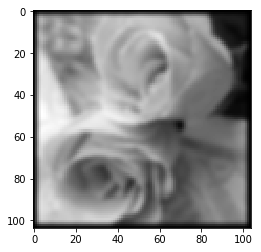

In [15]:
# convolving
blurred_image = np.dot(image_conv_mat, flat_image)

# reshaping and plotting
blurred_image = np.reshape(blurred_image, (image_size, image_size))[4:,4:]
plt.imshow(blurred_image, cmap=plt.get_cmap('gray'))

The picture you saw at the start of this notebook was produced by code quite like the one written above. I just convolved the three RGB channels separately.

It's evident that this is just a paricular example of what we can do by convolving a specific filter with an image. Another common application, which shows just how much the result depends on the filter, is edge detection. Without going into details watch how the image changes when we convolve the following filter with it.

$$ E = \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 8 & -1 \\
    -1 & -1 & -1
\end{bmatrix}
$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


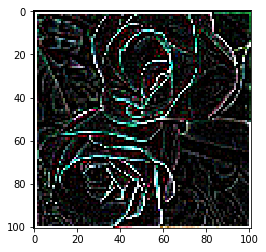

In [8]:
# bulding filter
weight_size = 3
edge_weight = -np.ones((weight_size, weight_size))
edge_weight[1,1] = 8

# padding and flattening image
image_padding = ((weight_size - 1, weight_size - 1), (weight_size - 1, weight_size - 1), (0,0))
flat_image = np.pad(image, image_padding, 'constant')
image_size = flat_image.shape[0]
flat_image = np.transpose(flat_image, (2, 0, 1)).reshape(3, image_size ** 2)

# padding and flatteining filter
weight_padding = (
    (0, image_size - weight_size), 
    (0, image_size - weight_size)
) 
flat_weight = np.pad(edge_weight, weight_padding, 'constant')

# building circulant matrix
image_conv_mat = linalg.circulant(flat_weight)

# convolving
final_image = []
for k in range(3):
    result = np.dot(flat_image[k], image_conv_mat)
    result = np.reshape(result, (image_size, image_size))[:-weight_size, :-weight_size]
    final_image.append(result)

# making RGB image
result = np.transpose(np.stack(final_image), (1,2,0)) / 255

# showing result
plt.imshow(result)
plt.show()

From this we can call an edge any pixel with a value above a number of our choice in $[0,1]$. Of course in general you'd have to be very clever to come up with a filter that actually does something useful when convolved.

A popular design of neural network layers, which in 2011 sparked the current AI revolution, is the convolutional neural network. One layer of such a network does nothing but apply a convolution with a filter of predetermined size, except this time the filter coefficients are not speecified by some clever human, but learned through a statistical optimization algorithm. In simple terms the network is left to learn by itself what's the best convolution for its purposes!

## Improving speed

If you executed the code above live you'll have noticed that some parts take some seconds to complete. As I touched on before this way of performing the convolution is quite slow. When we were dealing with simple vectors in section 1, this wasn't really an issue, but with images it becomes an important factor. Just imagine having to convolve a full HD image, you'd have to build a matrix $(1920 \cdot 1080) \times (1920 \cdot 1080)$, that's more than $4 \cdot 10^{12}$ floating point numbers!

TBC: FFT